In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import assert_all_finite
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC 
import pandas_datareader.data as web 
from sklearn.linear_model import SGDClassifier

In [2]:
start = '2005-01-03'
end = '2018-12-31'

In [4]:
csv = pd.read_csv('NYSE_prices_daily.csv')
lista_kompanija = list(csv.columns)[1:] #Loading the names of companies
lista_kompanija = lista_kompanija
dict_kompanija = {}

In [ ]:
for kompanija in lista_kompanija:
    try:
        dict_kompanija[kompanija] = web.DataReader(kompanija, 'yahoo', start, end) 
    except:
        print("Greška kod " + kompanija) #Remove the companies which don't have all the dates in the given range

In [6]:
lista_kompanija = set(lista_kompanija).intersection(set(dict_kompanija.keys()))

In [7]:
#Constructing a dataset where I will train on 70% of the data and test on 30%

frames = dict_kompanija.values()
df_all = pd.concat(frames) #Connecting all of the companies in one dataframe (training on 70%, testing on 30%)
prices_all = list(df_all["Adj Close"]) #Get the prices of all the companies
volume_all = list(df_all["Volume"]) #Get the volume of all the companies

In [9]:
#Splitting the dataset into training and testing sets

train_set = []
test_set = []
for kompanija in dict_kompanija.values():
    X,y = train_test_split(kompanija)
    train_set.append(X)
    test_set.append(y)

df_time_train = pd.concat(train_set)
df_time_test = pd.concat(test_set)

prices_time_train = list(df_time_train["Adj Close"])
volume_time_train = list(df_time_train["Volume"])
prices_time_test = list(df_time_test["Adj Close"])
volume_time_test = list(df_time_test["Volume"])

### Constructing various trading indicators

#### Moving average convergence/divergence indicator

In [10]:
def macd_func(df):
    df_macd = df.copy()
    exp1 = df_macd["Close"].ewm(span=12, adjust=False).mean() #12 day EMA (exponential moving average)
    exp2 = df_macd["Close"].ewm(span=26, adjust=False).mean() #26 day EMA
    macd = exp1-exp2
    signal = macd.ewm(span=9, adjust=False).mean() #9 dana EMA
    
    #macd_array = list(1 * pd.Series(macd - signal > 0).dropna()) 
        
    return macd.tolist(), signal.tolist() 

In [11]:
macd, signal = macd_func(df_all[100:150])

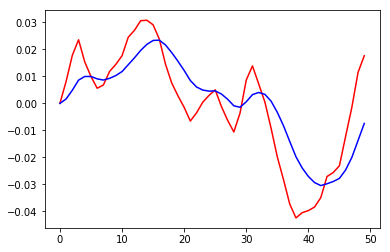

In [12]:
plt.plot(macd, color = 'red')
plt.plot(signal, color='blue')
plt.show()

In [14]:
crossed(macd, signal)

10

In [13]:
#Calculate how many time have the 12 day and 26 day moving averages crossed

def crossed(price1, price2):
    counter = 0
    presjek = 0
    for i in range(len(price1)):
        if((presjek == 0) and (price1[i] <= price2[i])):
            counter += 1
            presjek = 1
        if((presjek == 1) and (price1[i] > price2[i])):
            counter += 1
            presjek = 0
    return counter

In [15]:
#Calculate have the two lines crossed

def crossed2(price1, price2):
    for i in range(len(price1)):
        if (price1[i] <= price2[i]):
            return 1 #if they cross I return 1
    return 0

#### Average true range

In [16]:
def atr(df):
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())

    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)

    atr = true_range.rolling(14).sum()/14
    return atr.dropna()

#### Williams %R

In [17]:
def williams_indicator(df):
    highh = df['High'].rolling(14).max() 
    lowl = df['Low'].rolling(14).min()
    wr = -100 * ((highh - df['Close']) / (highh - lowl))
    return wr.dropna()

#### Stochastic Oscilator

In [18]:
def stochastic_oscilator(df):
    
    #Calculating the column of the lowest price in the last 14 days
    df_stochastic = df.copy()
    df_stochastic['L14'] = df_stochastic['Low'].rolling(window=14).min()

    #Calculating the column of the highest price in the last 14 days
    df_stochastic['H14'] = df_stochastic['High'].rolling(window=14).max()

    #Calculating the values of the stochastic indicator
    df_stochastic['%K'] = 100*((df_stochastic['Close'] - df_stochastic['L14']) /
                               (df_stochastic['H14'] - df_stochastic['L14']) )

    df_stochastic_serija = df_stochastic["%K"]

    return list(df_stochastic_serija.dropna())

#### RSI 2

In [19]:
def rsi2(close, window_length):
    #Calculating the difference in prices
    delta = pd.Series(close).diff()
    
    #Remove the first NaN row
    delta = delta[1:] 

    #Split the differences to positive and negative
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    #Calculating the EMA
    roll_up = up.ewm(span=window_length).mean()
    roll_down = down.abs().ewm(span=window_length).mean()

    #Calculating the RSI with the help of EMA
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    RSI_adj = RSI[1:]
    
    return RSI_adj

#### Function for constructing our vectors X for training the model

In [24]:
def calc(daysObservation, daysMark, indicator, df, prices, volume):
    trenutni = []
    
    df = df.copy()
        
    step = daysObservation + daysMark

    odmak = len(prices) % step

    X = []
    y = []
    prices_observation = []
    for i in range(0, len(prices) - odmak, step):
        prices_observation = prices[i:i+daysObservation]
        prices_observation.extend(volume[i:i+daysObservation]) #Adding trading volume X
        
        prices_observation.extend(rsi2(prices[i:i+daysObservation], daysObservation)) #Adding rsi to X
        
        #Adding the stochastic oscilator to X
        prices_observation.extend(stochastic_oscilator(df.iloc[i:i+daysObservation]))
        
        prices_observation.extend(atr(df.iloc[i:i+daysObservation])) #Adding average true range to X
        
        prices_observation.extend(williams_indicator(df.iloc[i:i+daysObservation])) #Adding williams indicator to X
        
        X.append(prices_observation)
        
        macd, signal = macd_func(df[i:i+step]) #calculating macd and signal for the whole period
        
        macd_look_forward = macd[daysObservation:step]
        signal_look_forward = signal[daysObservation:step] 
        
        if(crossed2(macd_look_forward, signal_look_forward)): #Checking has the line crossed in the last "look_forward" period
            y.append(0) #If it has, it signals a change to a negative trend (change of trend)
        else:
            y.append(1) #If it hasn't, it stays positive (continuation of trend)

    try:
        assert_all_finite(X)
    except ValueError:
        return "Greska sa X" #error with X
        
    try:
        assert_all_finite(y)
    except ValueError:
        return "Greska sa y" #error with y
        
    accuracy, f1, roc_auc = train(X,y,'all',0,0,0,0)
    
    return [daysObservation, daysMark, accuracy, f1, roc_auc]


#### Function for training the model

In [22]:
def train(X, y, mode, X_train, X_test, y_train, y_test):
    if(mode != 'time'):
        #Split the dataset in training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    #Scaling the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    clf = SGDClassifier()
    
    classes1 = np.array([0,1])
    
    #Splitting X and y
    
    X_split = np.array_split(X_train_scaled, 50)
    y_split = np.array_split(y_train, 50)
    
    clf.partial_fit(X_split[0], y_split[0], classes = classes1)
    
    for i in range(1, len(X_split)):
        clf.partial_fit(X_split[i], y_split[i])
    
    #Predictions of the model
    predictions = clf.predict(X_test_scaled)
    
    #Calculating different metrics
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictions)
    
    return accuracy, f1, roc_auc

#### Predictions and metrics when testing vertical universality (training on all the data from 70% of companies, testing on 30%)

In [ ]:
predictions = []
predictions_dict = {}
predictions_list_dict = []
daysObservation_array = [26]
daysMark_array = [9] 

indicator_array =  ['macd']

for indicator in indicator_array:
    for daysObservation in daysObservation_array:
        for daysMark in daysMark_array:
            predictions = calc(daysObservation, daysMark, indicator, df_all, prices_all, volume_all)
            
            predictions_dict = {'indicator': indicator, 'days_observed': predictions[0], 'days_marked': predictions[1],
                             'accuracy':predictions[2], 'f1_score':predictions[3], 'auc_roc': predictions[4]}
            predictions_list_dict.append(predictions_dict)

In [27]:
predictions_list_dict

[{'indicator': 'macd',
  'days_observed': 26,
  'days_marked': 9,
  'accuracy': 0.8667493796526055,
  'f1_score': 0.6815789473684211,
  'auc_roc': 0.8078938958133588}]

#### Predictions and metrics when testing time universality (training on 70% of the data from all companies, testing on 30%)

In [ ]:
X_train, y_train = calc(26, 9, 'macd', df_time_train, prices_time_train, volume_time_train)
X_test, y_test = calc(26, 9, 'macd', df_time_test, prices_time_test, volume_time_test)
predictions = train(0, 0, 'time', X_train, X_test, y_train, y_test)

In [29]:
predictions_dict = {'indicator': 'macd', 'days_observed': 26, 'days_marked': 9,
                             'accuracy':predictions[0], 'f1_score':predictions[1], 'auc_roc': predictions[2]}
predictions_dict

{'indicator': 'macd',
 'days_observed': 26,
 'days_marked': 9,
 'accuracy': 0.8686567164179104,
 'f1_score': 0.77906976744186046,
 'auc_roc': 0.8004252565406305}